In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.integrate import solve_ivp
import pysindy as ps
from scipy.signal import savgol_filter
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import random
from scipy.optimize import minimize
import cvxpy as cp

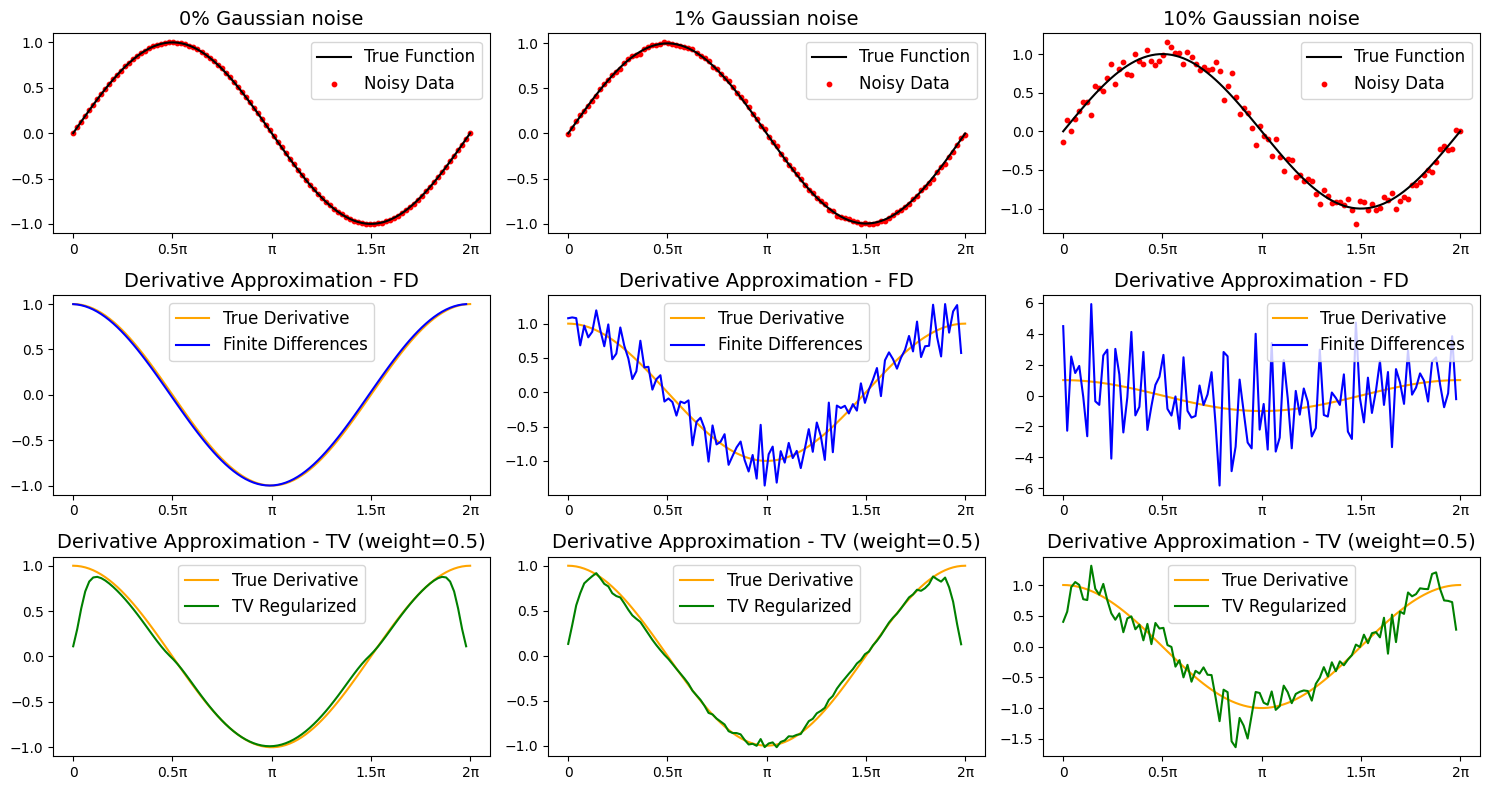

In [2]:
# Define the true function and its derivative
x = np.linspace(0, 2 * np.pi, 100)
true_y = np.sin(x)
true_derivative = np.cos(x)

def compute_derivatives(noise_amplitude):
    noise = np.random.normal(0, noise_amplitude, true_y.shape)
    noisy_y = true_y + noise

    # Standard Finite Differences
    fd_derivative = np.diff(noisy_y) / np.diff(x)
    
    # TV Regularization
    tv_denoised_y = denoise_tv_chambolle(noisy_y, weight=0.5)
    tv_derivative = np.diff(tv_denoised_y) / np.diff(x)

    return noisy_y, fd_derivative, tv_derivative

# Define noise levels: 0%, 1%, 5%
noise_levels = [0, 0.01, 0.1]
titles = ["0% Gaussian noise", "1% Gaussian noise", "10% Gaussian noise"]
fd_derivative_titles = ["Derivative Approximation - FD", "Derivative Approximation - FD", "Derivative Approximation - FD"]
tv_derivative_titles = ["Derivative Approximation - TV (weight=0.5)", "Derivative Approximation - TV (weight=0.5)", "Derivative Approximation - TV (weight=0.5)"]

fig = plt.figure(figsize=(15, 8))

# Define ticks and tick labels
ticks = [0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
tick_labels = ['0', '0.5π', 'π', '1.5π', '2π']

for idx, noise_level in enumerate(noise_levels, 1):
    noisy_y, fd_derivative, tv_derivative = compute_derivatives(noise_level * np.max(np.abs(true_y)))
    
    # First row: noisy data with true function
    plt.subplot(3, 3, idx)
    plt.plot(x, true_y, label="True Function", color='black')
    plt.scatter(x, noisy_y, s=10, label="Noisy Data", color='red')
    plt.title(titles[idx-1],fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(ticks, tick_labels)
    
    # Add title for FD derivative approximations
    plt.subplot(3, 3, idx + 3)
    plt.title(fd_derivative_titles[idx-1],fontsize=14)
    plt.plot(x, true_derivative, label="True Derivative", color='orange')
    plt.plot(x[:-1], fd_derivative, label="Finite Differences", color='blue')
    plt.legend(fontsize=12)
    plt.xticks(ticks, tick_labels)

    # Add title for TV derivative approximations
    plt.subplot(3, 3, idx + 6)
    plt.title(tv_derivative_titles[idx-1],fontsize=14)
    plt.plot(x, true_derivative, label="True Derivative", color='orange')
    plt.plot(x[:-1], tv_derivative, label="TV Regularized", color='green')
    plt.legend(fontsize=12)
    plt.xticks(ticks, tick_labels)

plt.tight_layout()
plt.show()

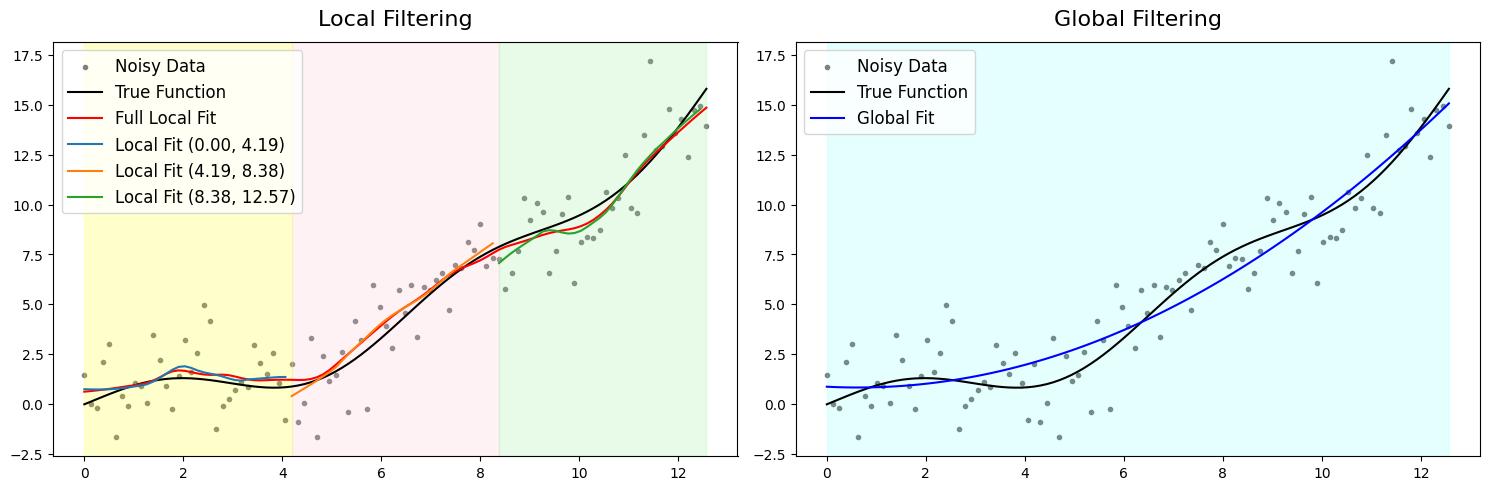

In [3]:
# Generate data points
x = np.linspace(0, 4 * np.pi, 100).reshape(-1, 1)
y_true = np.sin(x).ravel() + 0.1 * x.ravel()**2

# Add increased noise
noise = np.random.normal(0, 1.5, y_true.shape)  # Increased standard deviation to 1.5
y_noisy = y_true + noise

# Global Smoothing with 2nd-degree Polynomial Fit
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(x)
poly_reg = LinearRegression().fit(X_poly, y_noisy)
y_poly_pred = poly_reg.predict(X_poly)

# Full LOESS smoothing
y_full_loess = lowess(y_noisy, x.ravel(), frac=0.2)[:, 1]

# Define segments for Local Smoothing - Equal sized regions
total_range = 4 * np.pi
segment_size = total_range / 3
segments = [(i, i+segment_size) for i in np.arange(0, total_range, segment_size)]
colors = ['yellow', 'pink', 'lightgreen']

plt.figure(figsize=(15, 5))  # Adjusted figure size for side by side

# Plot for Local Smoothing
plt.subplot(1, 2, 1)  # Changed to 1 row, 2 columns configuration
plt.scatter(x, y_noisy, color='grey', marker='.', label='Noisy Data')
plt.plot(x, y_true, 'k-', label='True Function')
plt.plot(x, y_full_loess, 'r-', label='Full Local Fit')
for idx, (start, end) in enumerate(segments):
    mask = (x.ravel() >= start) & (x.ravel() < end)  # Use '<' for the end to avoid overlap
    x_segment = x[mask]
    y_noisy_segment = y_noisy[mask]
    y_loess_segment = lowess(y_noisy_segment, x_segment.ravel(), frac=0.5)[:, 1]
    plt.plot(x_segment, y_loess_segment, label=f'Local Fit ({start:.2f}, {end:.2f})')
    plt.axvspan(start, end, color=colors[idx], alpha=0.2)  # shading the region

plt.legend(fontsize=12)
plt.title("Local Filtering", fontsize=16,y=1.02)

# Plot for Global Smoothing
plt.subplot(1, 2, 2)  # Changed to 1 row, 2 columns configuration
plt.scatter(x, y_noisy, color='grey', marker='.', label='Noisy Data')
plt.plot(x, y_true, 'k-', label='True Function')
plt.plot(x, y_poly_pred, 'b-', label='Global Fit')
plt.axvspan(0, 4*np.pi, color='cyan', alpha=0.1)  # Shading for global fit
plt.legend(fontsize=12, loc='upper left')
plt.title("Global Filtering", fontsize=16,y=1.02)

plt.tight_layout()
plt.show()

In [4]:
def l1_trend_filter(y, lamb=0):
    n = len(y)
    x = cp.Variable(n)
    
    # Construct the 2nd order difference matrix D2
    D = np.diff(np.eye(n), axis=0)
    D2 = np.diff(D, axis=0)
    
    # Define the objective
    objective = cp.Minimize(0.5 * cp.norm(x - y, 2)**2 + lamb * cp.norm(D2 @ x, 1))
    
    # Solve the problem
    problem = cp.Problem(objective)
    problem.solve()
    
    return x.value

def savgol_denoise_1D(data, window_length=7,poly_order=3):
    denoised_data = savgol_filter(data, window_length, poly_order)  
    return denoised_data

def add_noise(data, percentage=0):
    # additive white gaussian noise
    noise_std = np.std(data) * (percentage / 100.0)
    noise = np.random.normal(0, noise_std, data.shape)
    return data + noise

def pareto_l1_lambda(u):
    lambdas = np.logspace(-4, 2, 50)
    solution_norms = []
    residual_norms = []
    for lambda_reg in lambdas:
        # Apply L1 Trend Filter
        u_denoised = l1_trend_filter(u, lambda_reg)
        residual = u - u_denoised
        solution_norms.append(np.linalg.norm(u_denoised))
        residual_norms.append(np.linalg.norm(residual))
    solution_norms = np.array(solution_norms)
    residual_norms = np.array(residual_norms)
    curvature = np.gradient(np.gradient(solution_norms, residual_norms), residual_norms)
    max_curvature_idx = np.argmax(np.abs(curvature))
    optimal_lambda = lambdas[max_curvature_idx]
    return optimal_lambda

def pareto_savgol_w(u):
    windows = [i for i in range(5, 101, 2)]
    solution_norms = []
    residual_norms = []
    for w in windows:
        u_denoised = savgol_denoise_1D(u, w, 3)
        residual = u - u_denoised
        solution_norms.append(np.linalg.norm(u_denoised))
        residual_norms.append(np.linalg.norm(residual))
    solution_norms = np.array(solution_norms)
    residual_norms = np.array(residual_norms)
    curvature = np.gradient(np.gradient(solution_norms, residual_norms), residual_norms)
    max_curvature_idx = np.argmax(np.abs(curvature))
    optimal_w = windows[max_curvature_idx]
    return optimal_w

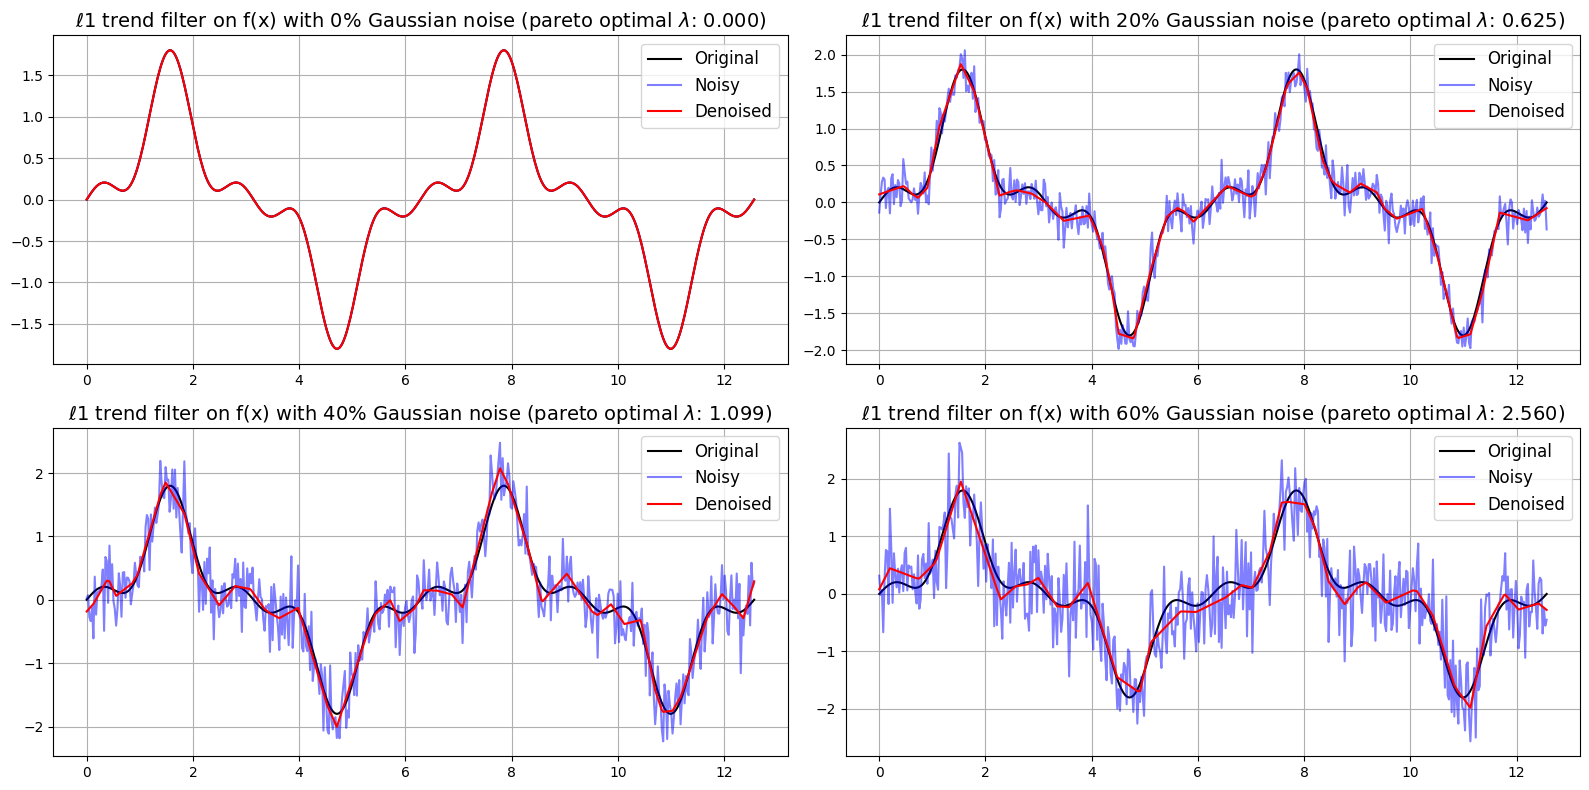

In [5]:
np.random.seed(52) 

# Define the mathematical function
def f(x):
    return np.sin(x) - 0.5 * np.sin(3 * x) + 0.3 * np.sin(5 * x)

# Generate x values and corresponding function values
x = np.linspace(0, 4 * np.pi, 500)
y = f(x)

def plot_comparison(noise_percentage, position):
    global yl1_40, yl1_60  # Declare the global variables
    y_noisy = add_noise(y, noise_percentage)
    if noise_percentage == 40:
        yl1_40 = y_noisy
    if noise_percentage == 60:
        yl1_60 = y_noisy
    optimal_lambda_value = pareto_l1_lambda(y_noisy)
    y_denoised = l1_trend_filter(y_noisy, optimal_lambda_value)

    # Setting subplot position
    plt.subplot(2, 2, position)
    plt.plot(x, y, 'k', label="Original", linewidth=1.5)
    plt.plot(x, y_noisy, 'b', label="Noisy", alpha=0.5)
    plt.plot(x, y_denoised, 'r', label="Denoised", linewidth=1.5)
    plt.legend(fontsize=12)
    plt.title(f"$\ell$1 trend filter on f(x) with {noise_percentage}% Gaussian noise (pareto optimal $\lambda$: {optimal_lambda_value:.3f})",fontsize=14)
    #plt.xlabel("x")
    #plt.ylabel("f(x)")
    plt.grid(True)
    plt.tight_layout()

# Creating the overall figure container for the 2x2 grid of plots
plt.figure(figsize=(16, 8))  # Adjusted figure size for grid

# Plotting for different noise levels
noise_levels = [0, 20, 40, 60]
for index, noise_level in enumerate(noise_levels):
    plot_comparison(noise_level, index + 1)  # +1 to adjust for subplot's 1-based indexing

plt.show()

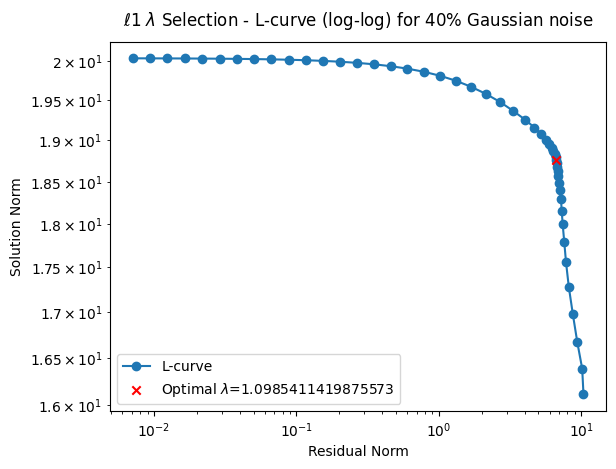

In [6]:
lambdas = np.logspace(-4, 2, 50)
solution_norms = []
residual_norms = []

for lambda_reg in lambdas:
    # Apply L1 Trend Filter
    y_denoised = l1_trend_filter(yl1_40, lambda_reg)
    residual = yl1_40 - y_denoised
    solution_norms.append(np.linalg.norm(y_denoised))
    residual_norms.append(np.linalg.norm(residual))

solution_norms = np.array(solution_norms)
residual_norms = np.array(residual_norms)
curvature = np.gradient(np.gradient(solution_norms, residual_norms), residual_norms)
max_curvature_idx = np.argmax(np.abs(curvature))
optimal_lambda = lambdas[max_curvature_idx]

# Plotting the L-curve
plt.loglog(residual_norms, solution_norms, '-o', label='L-curve', zorder=1)
plt.scatter(residual_norms[max_curvature_idx], solution_norms[max_curvature_idx], c='red', marker='x', label=f'Optimal $\lambda$={optimal_lambda}', zorder=2)
plt.xlabel('Residual Norm')
plt.ylabel('Solution Norm')
plt.title('$\ell$1 $\lambda$ Selection - L-curve (log-log) for 40% Gaussian noise',y=1.02)
plt.legend()
plt.show()

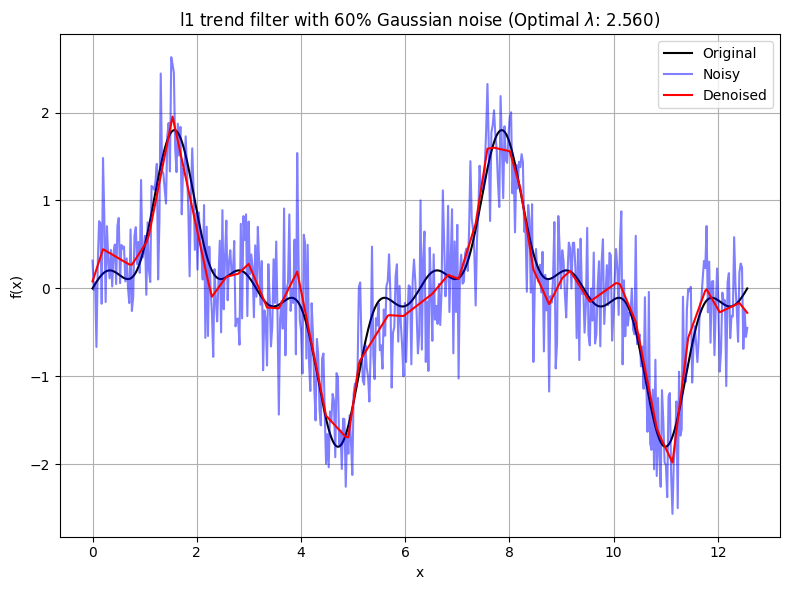

In [7]:
optimal_lambda_value = pareto_l1_lambda(yl1_60)
y_denoised = l1_trend_filter(yl1_60, optimal_lambda_value)

# Creating the overall figure container for the single plot
plt.figure(figsize=(8, 6))  # Adjusted figure size for a single plot

# Plotting the data
plt.plot(x, y, 'k', label="Original", linewidth=1.5)
plt.plot(x, yl1_60, 'b', label="Noisy", alpha=0.5)
plt.plot(x, y_denoised, 'r', label="Denoised", linewidth=1.5)
plt.legend()
plt.title(f"l1 trend filter with 60% Gaussian noise (Optimal $\lambda$: {optimal_lambda_value:.3f})")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.tight_layout()

plt.show()

In [8]:
optimal_w_value = pareto_savgol_w(y_denoised)
print(optimal_w_value)
denoised_data2 = savgol_denoise_1D(y_denoised, optimal_w_value)

39


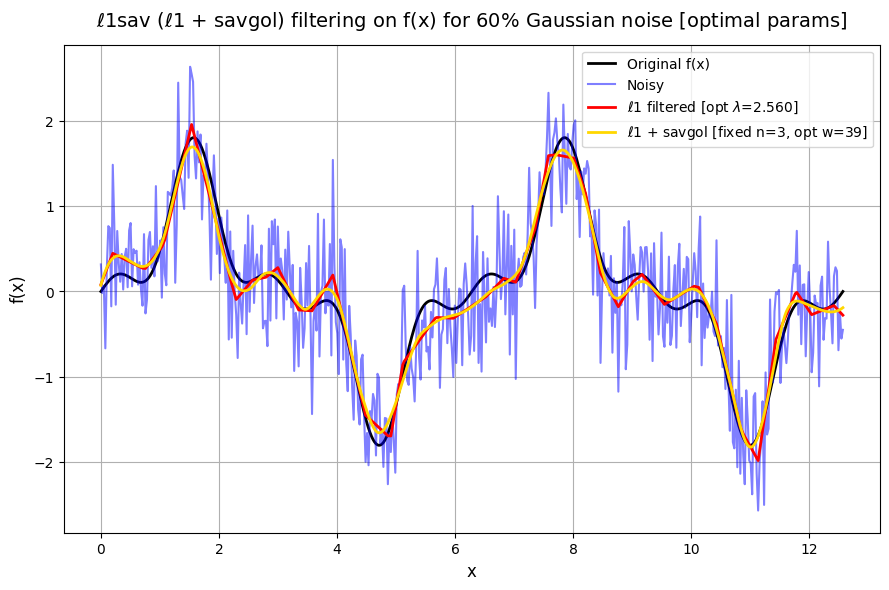

In [9]:
plt.figure(figsize=(9, 6))
plt.plot(x, y, 'k', label="Original f(x)", linewidth=2)
plt.plot(x, yl1_60, 'b', label="Noisy", alpha=0.5)
plt.plot(x, y_denoised, 'r', label="$\ell$1 filtered [opt $\lambda$=2.560]", linewidth=2)
plt.plot(x, denoised_data2, color='gold', label="$\ell$1 + savgol [fixed n=3, opt w=39]", linewidth=2)
plt.legend(loc='upper right')
plt.title("$\ell$1sav ($\ell$1 + savgol) filtering on f(x) for 60% Gaussian noise [optimal params]", fontsize=14,y=1.02)
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

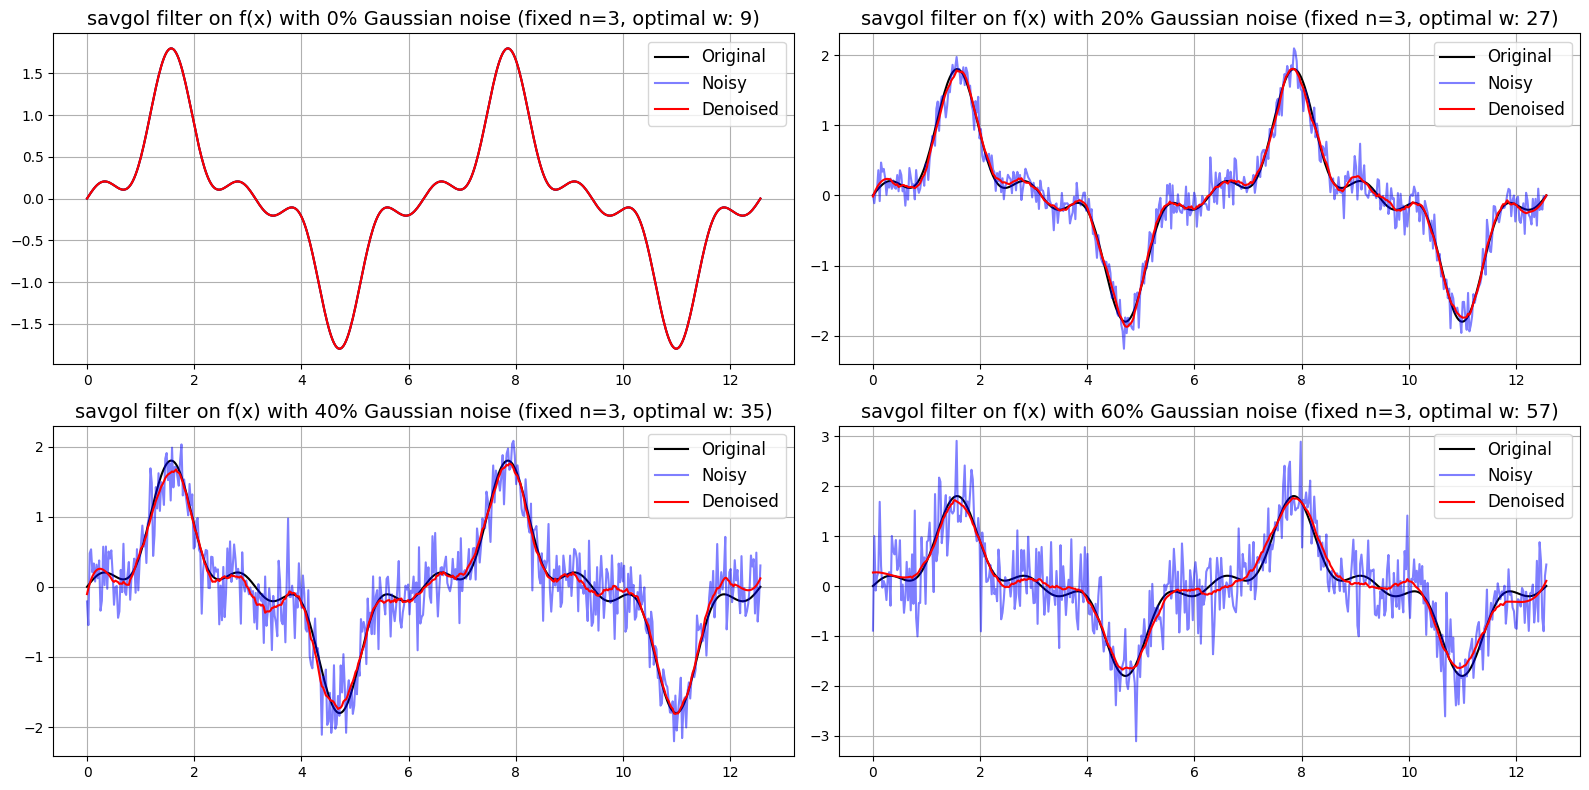

In [10]:
def plot_comparison(noise_percentage, position):
    global ysg_40, ysg_60  # Declare the global variables
    y_noisy = add_noise(y, noise_percentage)
    if noise_percentage == 40:
        ysg_40 = y_noisy
    if noise_percentage == 60:
        ysg_60 = y_noisy
    optimal_w = pareto_savgol_w(y_noisy)
    y_denoised = savgol_denoise_1D(y_noisy, optimal_w, 3)

    # Setting subplot position
    plt.subplot(2, 2, position)
    plt.plot(x, y, 'k', label="Original", linewidth=1.5)
    plt.plot(x, y_noisy, 'b', label="Noisy", alpha=0.5)
    plt.plot(x, y_denoised, 'r', label="Denoised", linewidth=1.5)
    plt.legend(fontsize=12)
    plt.title(f"savgol filter on f(x) with {noise_percentage}% Gaussian noise (fixed n=3, optimal w: {optimal_w})",fontsize=14)
    #plt.xlabel("x")
    #plt.ylabel("f(x)")
    plt.grid(True)
    plt.tight_layout()

# Creating the overall figure container for the 2x2 grid of plots
plt.figure(figsize=(16, 8))  # Adjusted figure size for grid

# Plotting for different noise levels
noise_levels = [0, 20, 40, 60]
for index, noise_level in enumerate(noise_levels):
    plot_comparison(noise_level, index + 1)  # +1 to adjust for subplot's 1-based indexing

plt.show()

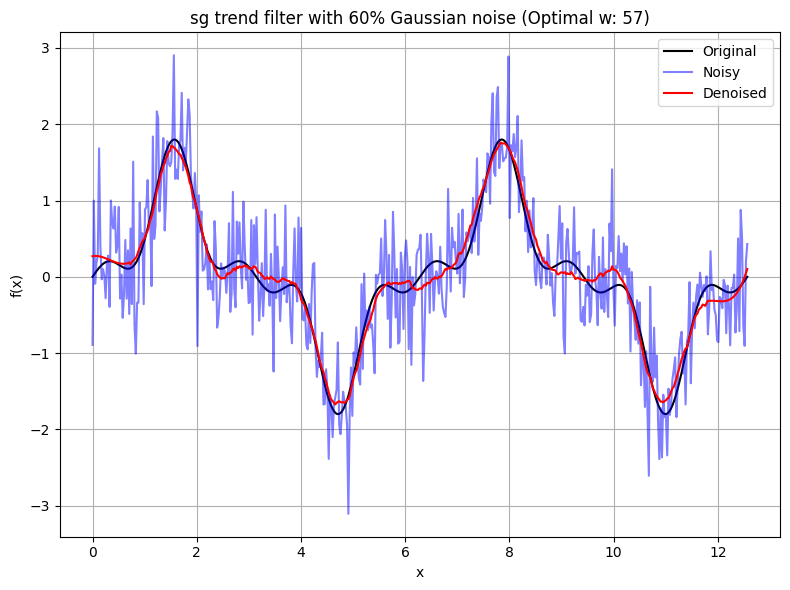

In [11]:
optimal_w = pareto_savgol_w(ysg_60)
y_denoised = savgol_denoise_1D(ysg_60, optimal_w,3)

# Creating the overall figure container for the single plot
plt.figure(figsize=(8, 6))  # Adjusted figure size for a single plot

# Plotting the data
plt.plot(x, y, 'k', label="Original", linewidth=1.5)
plt.plot(x, ysg_60, 'b', label="Noisy", alpha=0.5)
plt.plot(x, y_denoised, 'r', label="Denoised", linewidth=1.5)
plt.legend()
plt.title(f"sg trend filter with 60% Gaussian noise (Optimal w: {optimal_w})")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.tight_layout()

plt.show()

In [12]:
optimal_lambda = pareto_l1_lambda(y_denoised)
print(optimal_lambda)
denoised_data2 = l1_trend_filter(y_denoised, optimal_lambda)

0.0655128556859551


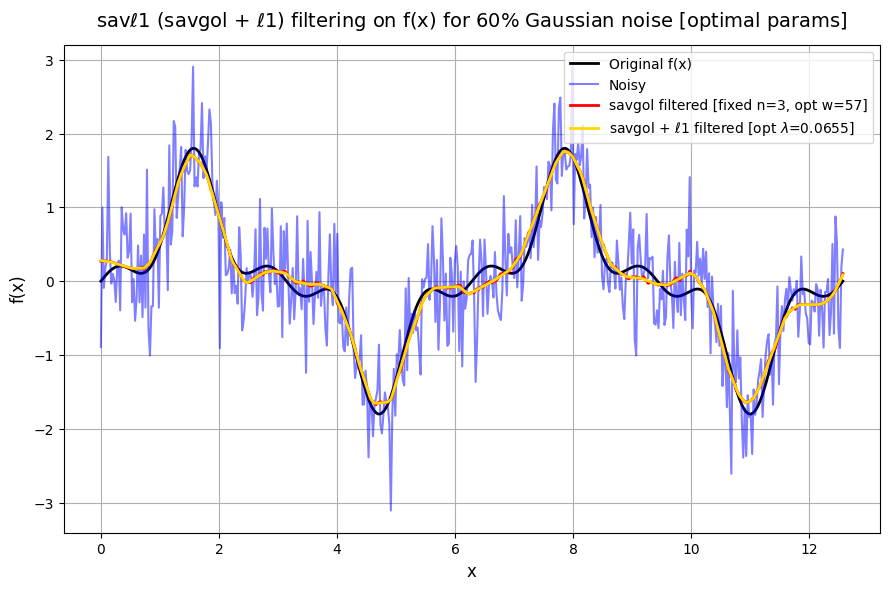

In [13]:
plt.figure(figsize=(9, 6))
plt.plot(x, y, 'k', label="Original f(x)", linewidth=2)
plt.plot(x, ysg_60, 'b', label="Noisy", alpha=0.5)
plt.plot(x, y_denoised, 'r', label="savgol filtered [fixed n=3, opt w=57]", linewidth=2)
plt.plot(x, denoised_data2, color='gold', label="savgol + $\ell$1 filtered [opt $\lambda$=0.0655]", linewidth=2)
plt.legend(loc = 'upper right')
plt.title("sav$\ell$1 (savgol + $\ell$1) filtering on f(x) for 60% Gaussian noise [optimal params]", fontsize=14,y=1.02)
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()